In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import copy

plt.style.use('ggplot')
pd.set_option('display.max_rows', 50)

In [2]:
def supported_years():
    geofile_folder = './data/geoBoundaries'
    years = []
    
    for file in os.listdir(geofile_folder):
        try:
            year = file.split('.')[0].split('_')[1]
        except:
            continue
        if not year.startswith('bc'):
            years.append(int(year))
    return sorted(years)

In [3]:
def map_year_geofile(year):
    all_years = supported_years()
    all_years.append(2050)

    for i in range(len(all_years)-1):
        if year >= all_years[i] and year < all_years[i+1]:
            valid_year = all_years[i]
            #print('Valid year: ', valid_year)
            break

    map_df = gpd.read_file(f'data/geoBoundaries/world_{valid_year}.geojson')

    try:
        map_df['NAME'] = map_df['NAME'].replace('Russian Empire', 'Russia')
    except:
        pass

    try:
        map_df['NAME'] = map_df['NAME'].replace('USSR', 'Russia')
    except:
        pass

    try:
        map_df['NAME'] = map_df['NAME'].replace('United Kingdom of Great Britain and Ireland', 'United Kingdom')
    except:
        pass
    
    map_df = map_df.set_index('NAME')
    return map_df[map_df.index.notna()]

In [4]:
def plot_edi_map(edi_df, current_map_df, year):
    edi_df = edi_df[edi_df['Year']==year]
    map_df = map_year_geofile(year)
    edi_map_df = map_df.join(edi_df, how='left')
    
    fig, ax = plt.subplots(1,1, figsize=(10,7))
    current_map_df.plot(color='grey', ax=ax)
    edi_map_df.plot(column='edi', 
                cmap='plasma', 
                legend=False,
                ax=ax
               )
    
    ax.axis('off')
    ax.set_title(f'Electoral democracy index {year}')
    
    # Add color gradient legend in custom axis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="10%", pad=0.1)
    cmap = cm.plasma
    norm = mcolors.Normalize(vmin=0, vmax=1)
    fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal')
    
    plt.tight_layout()
    plt.savefig(f"plots/map_plots/edi_map_{year}.png")
    plt.close()

## Electoral democracy index (edi_df)
Based on the expert estimates and index by V-Dem. It captures to which extent political leaders are elected under comprehensive voting rights
in free and fair elections, and freedoms of association and expression are guaranteed. It ranges from 0 to 1 (most democratic).

## Political regime (regime_df)
Based on the classification by Lührmann et al. (2018) and the estimates by V-Dem’s experts.

## Political regime Lexical Index (lexical_regime_df)
Based on the classification and estimates by Skaaning et al. (2015).

## Political regime Boix-Miller-Rosato (bmr_regime_df)
Based on the classification and estimates by Boix et al. (2013). Democracies are understood here as political systems in which political leaders
are elected under broad rights for men to vote in free and fair elections.

## Democracy index, 1776 to 2020 polity (polity_dem_df)
Based on the estimates and index by Polity 5 (2020). It captures the extent to which open, multi-party, and competitive elections choose a chief
executive who faces comprehensive institutional constraints, and political participation is competitive. It ranges from -10 to 10 (fully democratic).

## Political regime, Freedom House (fh_regime_df)
Based on the classification and estimates by Freedom House (2024). Free countries are understood here as political systems in which citizens
have many political rights (free and fair elections, political pluralism and participation, functioning government) and civil liberties (freedoms of
expression and association, rule of law, personal autonomy).

## Democratic features, Bertelmans Transformation Index (dem_features_df)
Based on the expert estimates and index by the Bertelsmann Transformation Index (2024). It combines information on the extent of political
participation, the rule of law, stable democratic institutions, political and social integration, and a capable state. It ranges from 1 to 10 (most
democratic).

## Democracy index, Economist Intelligence Unit (democ_idx_df)
Based on the expert estimates and index by the Economist Intelligence Unit (2006-2023). It combines information on the extent to which
citizens can choose their political leaders in free and fair elections, enjoy civil liberties, prefer democracy over other political systems, can and
do participate in politics, and have a functioning government that acts on their behalf. It ranges from 0 to 10 (most democratic).

In [5]:
# Read democracy datasets
edi_df = pd.read_csv("data/electoral-democracy-index.csv")
regime_df = pd.read_csv("data/political-regime.csv")
lexical_regime_df = pd.read_csv("data/political-regime-lexical.csv")
bmr_regime_df = pd.read_csv("data/political-regime-bmr.csv")
polity_dem_df = pd.read_csv("data/democracy-index-eiu.csv")
fh_regime_df = pd.read_csv("data/political-regime-fh.csv")
dem_features_df = pd.read_csv("data/democratic-features-bti.csv")
democ_idx_df = pd.read_csv("data/democracy-index-eiu.csv")

# Read shapefile for world plotting
map_df = gpd.read_file('data/geodata/World_Countries.shp')
map_df = map_df.set_index('COUNTRY')
continent_map_df = pd.read_csv('data/country_continent_map.csv')
continent_map_df = continent_map_df.drop('Unnamed: 0', axis=1)

# Read GDP dataset (https://ourworldindata.org/grapher/national-gdp-constant-usd-wb)
# GDP is adjusted for the 2015 USD
gdp_df = pd.read_csv("data/national-gdp-constant-usd-wb.csv")

edi_df = edi_df.rename({"Electoral democracy index (best estimate, aggregate: average)": 'edi'}, axis=1)
gdp_df = gdp_df.rename({"GDP (constant 2015 US$)": "GDP"}, axis=1)
continent_map_df = continent_map_df.rename({"iso_code": "Code"}, axis=1)

### Electoral democracy index

In [6]:
edi_df = edi_df.set_index('Entity')
edi_df = edi_df.dropna(how='all')

edi_1980_df = edi_df[edi_df['Year']==1980]
edi_2023_df = edi_df[edi_df['Year']==2023]
missing_countries = edi_2023_df[edi_2023_df.isna()]

In [ ]:
# plot images for every year in the data
for year in range(edi_df['Year'].min(), edi_df['Year'].max()+1):
    plot_edi_map(edi_df, map_df, year)

In [ ]:
image_folder = 'plots/map_plots'
video_name = 'plots/edi_map.mp4'
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images.sort()
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can use other codecs like 'XVID', 'MJPG', 'X264', etc.
video = cv2.VideoWriter(video_name, fourcc, 3, (width, height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

video.release()
cv2.destroyAllWindows()

# Boxplot of democracy index over the years

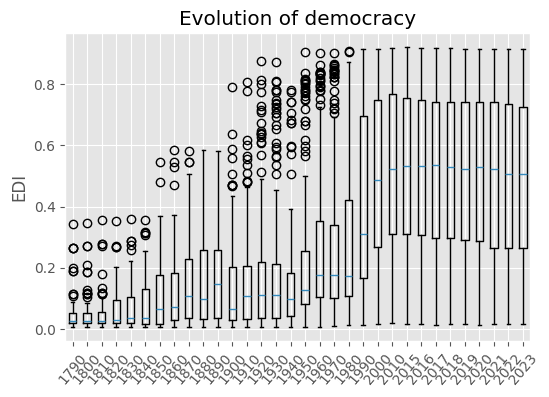

In [6]:
years = edi_df['Year'].unique()
years = [year for year in years if (year%10==0 or year>=2015)]
edi_arrays = []

fig, ax = plt.subplots(figsize=(6,4))

for year in years:
    year_df = edi_df[edi_df['Year']==year]
    edi_arrays.append(year_df['edi'].values)

ax.boxplot(edi_arrays, tick_labels=years)
plt.xticks(rotation=50)
plt.ylabel('EDI')
plt.title('Evolution of democracy')

plt.savefig("plots/edi_boxplots.png")
plt.show()

## Relationship between democracy index and gdp

In [ ]:
gdp_df = gdp_df.drop('Entity', axis=1)
gdp_df = pd.merge(gdp_df, edi_df, on=['Code', 'Year'], how='inner')
gdp_df = pd.merge(gdp_df, continent_map_df, on='Code')

#gdp_df = gdp_df[gdp_df['Year']>2020]

In [ ]:
continents = ['Asia', 'Europe', 'Africa', 'South America', 'Oceania', 'North America']
n = len(continents)
cmap = plt.get_cmap('viridis')

fig, axes = plt.subplots(n, 1, figsize=(12, n*7))

for i, continent in enumerate(continents):
    continent_gdp_df = copy(gdp_df[gdp_df['continent']==continent])
    continent_gdp_df['location_factor'] = pd.factorize(continent_gdp_df['location'])[0]
    axes[i].scatter(continent_gdp_df['GDP'], continent_gdp_df['edi'], c=continent_gdp_df['location_factor'], cmap=cmap)
    axes[i].set_title(continent)
    axes[i].set_xlabel("GDP")
    axes[i].set_ylabel("EDI")
    axes[i].set_xscale('log')

    unique_colors = np.unique(continent_gdp_df['location_factor'])
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i / (len(unique_colors) - 1)), markersize=10) for i in unique_colors]
    labels = [continent_gdp_df.loc[continent_gdp_df['location_factor']==idx, 'location'].values[0] for idx in unique_colors]

    divider = make_axes_locatable(axes[i])
    legend_ax_1 = divider.append_axes("right", size="10%", pad=0.01)
    legend_ax_1.legend(handles[:21], labels[:21], loc='upper left', frameon=False)

    legend_ax_2 = divider.append_axes("right", size="10%", pad=2.8)
    legend_ax_2.legend(handles[21:], labels[21:], loc='upper right', frameon=False)

    for ax in [legend_ax_1, legend_ax_2]:
        # Remove background color
        ax.set_facecolor('none')  # Set to 'none' or 'white'
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        
        # Remove ticks
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.xaxis.set_tick_params(width=0)
        ax.yaxis.set_tick_params(width=0)
        
        # Optionally remove tick labels as well
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    
    #axes[i][1].legend(handles[21:], labels[21:], loc='upper right', title="Countries")
plt.savefig("plots/gdp_democracy.png")

## Political Regimes

In [7]:
regime_df = pd.read_csv('data/political-regime.csv')
regime_mapping ={
    0: 'Closed autocracy',
    1: 'Electoral autocracy',
    2: 'Electoral democracy',
    3: 'Liberal democracy'
}

In [8]:
counted_regimes = regime_df[['Year', 'Political regime', 'Entity']].groupby(['Year', 'Political regime']).size().unstack(fill_value=0)

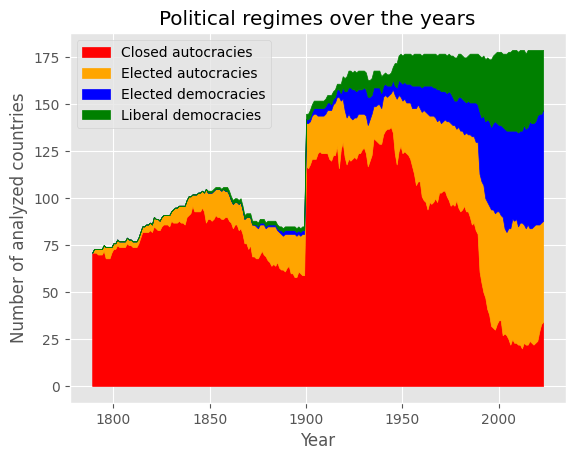

In [9]:
fig, ax = plt.subplots()

years = counted_regimes.index

closed_autocracies = np.array(counted_regimes[0])
elected_autocracies = np.array(counted_regimes[1]) + closed_autocracies
elected_democracies = np.array(counted_regimes[2]) + elected_autocracies
liberal_democracies = np.array(counted_regimes[3]) + elected_democracies


ax.fill_between(years, closed_autocracies, color='red', label='Closed autocracies')
ax.fill_between(years, closed_autocracies, elected_autocracies, color='orange', label='Elected autocracies')
ax.fill_between(years, elected_autocracies, elected_democracies, color='blue', label='Elected democracies')
ax.fill_between(years, elected_democracies, liberal_democracies, color='green', label='Liberal democracies')
ax.legend()
ax.set_ylabel('Number of analyzed countries')
ax.set_xlabel('Year')
ax.set_title('Political regimes over the years')
plt.savefig('plots/regimes.png')

In [10]:
edi_df = edi_df.reset_index()
regime_df = pd.merge(regime_df, edi_df, on=['Entity', 'Year'])

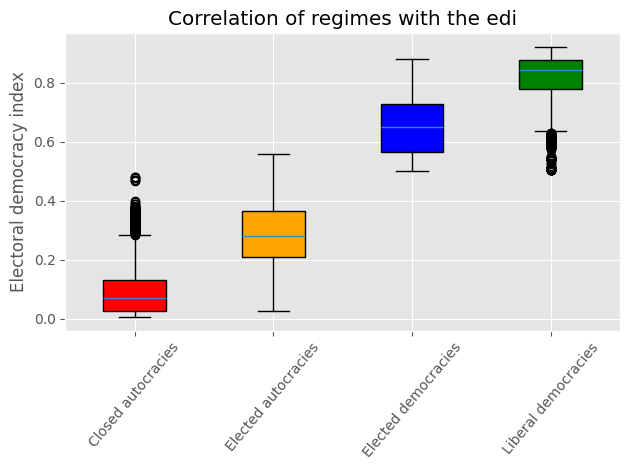

In [16]:
fig, ax = plt.subplots()
colors = ['red', 'orange', 'blue', 'green']

regime_arrays = []
for regime_idx in [0,1,2,3]:
    regime_arrays.append(regime_df[regime_df['Political regime']==regime_idx]['edi'].values)

box = plt.boxplot(
    regime_arrays, 
    tick_labels=['Closed autocracies', 'Elected autocracies', 'Elected democracies', 'Liberal democracies'],
    patch_artist=True
)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.xticks(rotation=50)
plt.ylabel('Electoral democracy index')
plt.title('Correlation of regimes with the edi')
plt.tight_layout()
plt.savefig('plots/regime_edi_correlation1.png')
#plt.subplots_adjust(bottom=0.2)  # 

plt.show()